# Климат Москвы: среднемесячные температуры

Источники: ист-данные - http://meteo.ru/data/156-temperature через их интерфейс одним файлом. Логин-пароль: Egor1971, dragon
Эти ребята дают с 1948 до 2019-го года включительно (возможно, потом появятся и дальше)

https://www.gismeteo.ru/diary/4368/2020/10/ - отсюда данные по дням с окончания первого источника и по настоящее время - качать и усреднять

In [1]:
import pandas as pd
import datetime as dt
import requests
from bs4 import BeautifulSoup as BS
import re
import calendar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

## Обработка исторических данных (файл должен быть скачан и положен в корень этого блокнота)

In [2]:
pdfH = pd.read_csv('wr93033.txt', sep=';', header=None, names=['StID', 'year'] + list(range(1, 13)), index_col='year')
pdfH=pdfH[range(1, 13)].stack().reset_index()
pdfH['date'] = pdfH.apply(lambda x: dt.datetime(day=1, month=int(x['level_1']), year = int(x['year'])), axis=1)
pdfH = pdfH[['date', 0]].rename(columns={0:'tempC'})
pdfH

,date,tempC
0,1948-01-01,-7.8
1,1948-02-01,-10.7
2,1948-03-01,-4.4
3,1948-04-01,5.9
4,1948-05-01,15.3
...,...,...
859,2019-08-01,16.4
860,2019-09-01,12.3
861,2019-10-01,8.8
862,2019-11-01,1.8


## Обработка данных за недостающие года - с Дневника погоды Гисметео

In [3]:
terCode=296841
# terCode=168877

strURL=r'https://www.gismeteo.ru/diary/{ter_code}/{year}/{month_num}/'

lMonthNames = list(map(str.lower, calendar.month_name[1:]))
lMonthNum = list(range(1, 13))
years = list(range(pdfH['date'].max().year+1, dt.datetime.now().year+1))

In [4]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.chrome.options import Options as CHROptions
import selenium.webdriver.chrome.service as service

from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.remote.command import Command
from selenium.webdriver.common.keys import Keys

str_def_dir_dwld=r'/home/egor/Загрузки' #'/home/egor/tmp'
#str_def_dir_dwld='/home/egor/tmp'
#strInn='7708503727'

def get_chromium():
    chrome_path='/usr/lib/chromium-browser/chromedriver'

#     service=service.Service('/usr/bin/chromium-browser')
#     service.start()
    options=CHROptions()
    #options.add_argument('--headless')
    options.add_argument('download.default_directory={}'.format(str_def_dir_dwld))
    driver=webdriver.Chrome(executable_path=chrome_path, options=options)
    driver.implicitly_wait(10)
    return driver

In [5]:
def read_temp():
    def get_info(month=None, year=None):
        driver.implicitly_wait(10)
        driver.get(strURL.format(month_num=month, year = year, ter_code=terCode))
        mess = BS(driver.page_source, 'html.parser')
        
        tbls = mess.find_all('table')
        try:
            trs = tbls[0].find_all('tr')
        except IndexError:
                return None
        _result = list()
        for r in trs:
            tdf = r.find_all('td')
            if tdf and tdf[0].text.isdigit():
                tD = pd.to_numeric(tdf[1].text, errors='coerce')
                tN = pd.to_numeric(tdf[6].text, errors='coerce')
                _result.append(np.nanmean([tD, tN]))
        
        return np.nanmean(_result)

    
    driver =  get_chromium() # get_firefox()
    _res=list()
    for y in years:
        for m in lMonthNum:
            r = get_info(month=m, year=y)
            if r:
                _res.append({'date':dt.datetime(day=1, month=m, year=y),
                             'tempC':r})
            else:
                break
    driver.quit()
    return pd.DataFrame(_res)

res=read_temp()


In [6]:
res

,date,tempC
0,2020-01-01,0.032258
1,2020-02-01,0.482759
2,2020-03-01,5.016129
3,2020-04-01,6.200000
4,2020-05-01,13.016129
5,2020-06-01,20.733333
6,2020-07-01,19.451613
7,2020-08-01,19.225806
8,2020-09-01,15.316667
9,2020-10-01,10.145161


In [7]:
pdfTemp=pd.concat([pdfH, res])
pdfTemp

,date,tempC
0,1948-01-01,-7.800000
1,1948-02-01,-10.700000
2,1948-03-01,-4.400000
3,1948-04-01,5.900000
4,1948-05-01,15.300000
...,...,...
17,2021-06-01,22.483333
18,2021-07-01,24.083333
19,2021-08-01,21.209677
20,2021-09-01,10.266667


## Данные недостающих лет из Вики (метеостанция ВДНХ)

https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%B5%D0%BE%D1%81%D1%82%D0%B0%D0%BD%D1%86%D0%B8%D1%8F_%D0%92%D0%94%D0%9D%D0%A5

In [3]:
urlVDNH = r'https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%B5%D0%BE%D1%81%D1%82%D0%B0%D0%BD%D1%86%D0%B8%D1%8F_%D0%92%D0%94%D0%9D%D0%A5'

In [4]:
vdnh = requests.get(urlVDNH)
vdnh

<Response [200]>

In [5]:
lstMonthNames = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек',]
dctMNums = dict(zip(lstMonthNames, range(1, 13)))

vdnhSP = BS(vdnh.text, 'html.parser')
tbls=vdnhSP.find_all(name='table', attrs={'class':'wikitable'})

tdh = vdnhSP.find_all(name=lambda x:x.name=='th' and 'Среднемесячная температура,' in x.text)
table = tdh[0].parent.parent.parent

trs = table.find_all('tr')
# print(trs)
trt=list()
for r in trs:
    tdh = r.find_all('th')
    trt.append([td.text.strip() for td in tdh])
res=list()
for r in trt[2:]:
    res.append(dict(zip(trt[1], r)))
_pdfTemp = pd.DataFrame(res)
_pdfTemp['year'] = _pdfTemp['Месяц'].apply(lambda x: int(re.search('\d{4}', x).group(0)))
_pdfTemp = _pdfTemp.set_index('year')[lstMonthNames]

_pdfTemp = _pdfTemp.applymap(lambda x: pd.to_numeric(x.replace(',', '.').replace('−', '-'), errors='coerce')).stack()

_pdfTemp = _pdfTemp.reset_index().rename(columns={'level_1':'m', 0:'tempC'})
_pdfTemp['date'] = _pdfTemp.apply(lambda x: dt.datetime(day=1, month = dctMNums[x['m']], year=x['year']), axis=1)
_pdfTemp = _pdfTemp[['date', 'tempC']]
_pdfTemp

,date,tempC
0,1981-01-01,-5.4
1,1981-02-01,-4.9
2,1981-03-01,-3.1
3,1981-04-01,3.3
4,1981-05-01,14.0
...,...,...
484,2021-05-01,14.3
485,2021-06-01,20.5
486,2021-07-01,22.2
487,2021-08-01,19.5


# Графики

In [6]:
lstSeas = ['зима', 'весна', 'лето', 'осень']
dctSeas = dict(zip(range(1,5), lstSeas ))

lstMonthNames = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек',]
dctMNums = dict(zip(lstMonthNames, range(1, 13)))
dctMonths = dict(zip(range(1, 13), lstMonthNames))

def plot_temp1(pdf, legends_dict=dctSeas, colors=['teal', 'limegreen', 'orange', 'indianred']):
    
    cnt = len(pdf.columns)
    widths = [8, 2]
    axs = list()
    
    fig2 = plt.figure(constrained_layout=True, figsize=(17, 3*cnt))
    spec2 = gridspec.GridSpec(ncols=2, nrows=cnt, figure=fig2, width_ratios=widths)
    
    for i in pdf.columns:
        if i==1:
            ax1 = fig2.add_subplot(spec2[i-1, 0])
            ax2 = fig2.add_subplot(spec2[i-1, 1], sharey=ax1)
        else:
            ax1 = fig2.add_subplot(spec2[i-1, 0], sharex=axs[0][0])
            ax2 = fig2.add_subplot(spec2[i-1, 1], sharey=ax1, sharex=axs[0][1])  
            
        pdf[i].plot.line(ax=ax1, grid=True, rot=90, xticks=pdf.index, xlabel='', color=colors[i-1])
        _p = pdf[[i]].copy()
        _p['до потепления'] = _p.loc[:climate_change, i]
        _p['потепление'] = _p.loc[climate_change:, i]
        _p.boxplot(column=['до потепления', 'потепление'], ax=ax2)
        
        ax1.legend(labels = [legends_dict[i],], loc=2)
        y1 = np.mean(pdf.loc[:climate_change, i])
        y2 = np.mean(pdf.loc[climate_change:, i])
        ax1.hlines(y=y1, xmin=pdf.index.min(), xmax=climate_change, colors=['k'], linestyles='dashed', lw=0.7)
        ax1.hlines(y=y2, xmin=climate_change, xmax=pdf.index.max(), colors=['k'], linestyles='dashed', lw=0.7)

        axs.append([ax1, ax2])
        
    return axs

## Сборка результирующего фрейма

In [7]:
# данные последних лет - с Вики (метеостанция ВДНХ) - точнее
mosTemp = pdfH.set_index('date').merge(_pdfTemp.set_index('date'), how='outer',
                                       left_index=True, right_index=True) 
mosTemp['tempC_x'].update(mosTemp['tempC_y'])
mosTemp['tempC'] = mosTemp['tempC_x']
mosTemp = mosTemp[['tempC']]

# mosTemp = pdfTemp.set_index('date') # данные последних лет - из 'Дневника погоды'
print(mosTemp)

            tempC
date             
1948-01-01   -7.8
1948-02-01  -10.7
1948-03-01   -4.4
1948-04-01    5.9
1948-05-01   15.3
...           ...
2021-05-01   14.3
2021-06-01   20.5
2021-07-01   22.2
2021-08-01   19.5
2021-09-01    9.9

[885 rows x 1 columns]


### Сравнение по месяцам

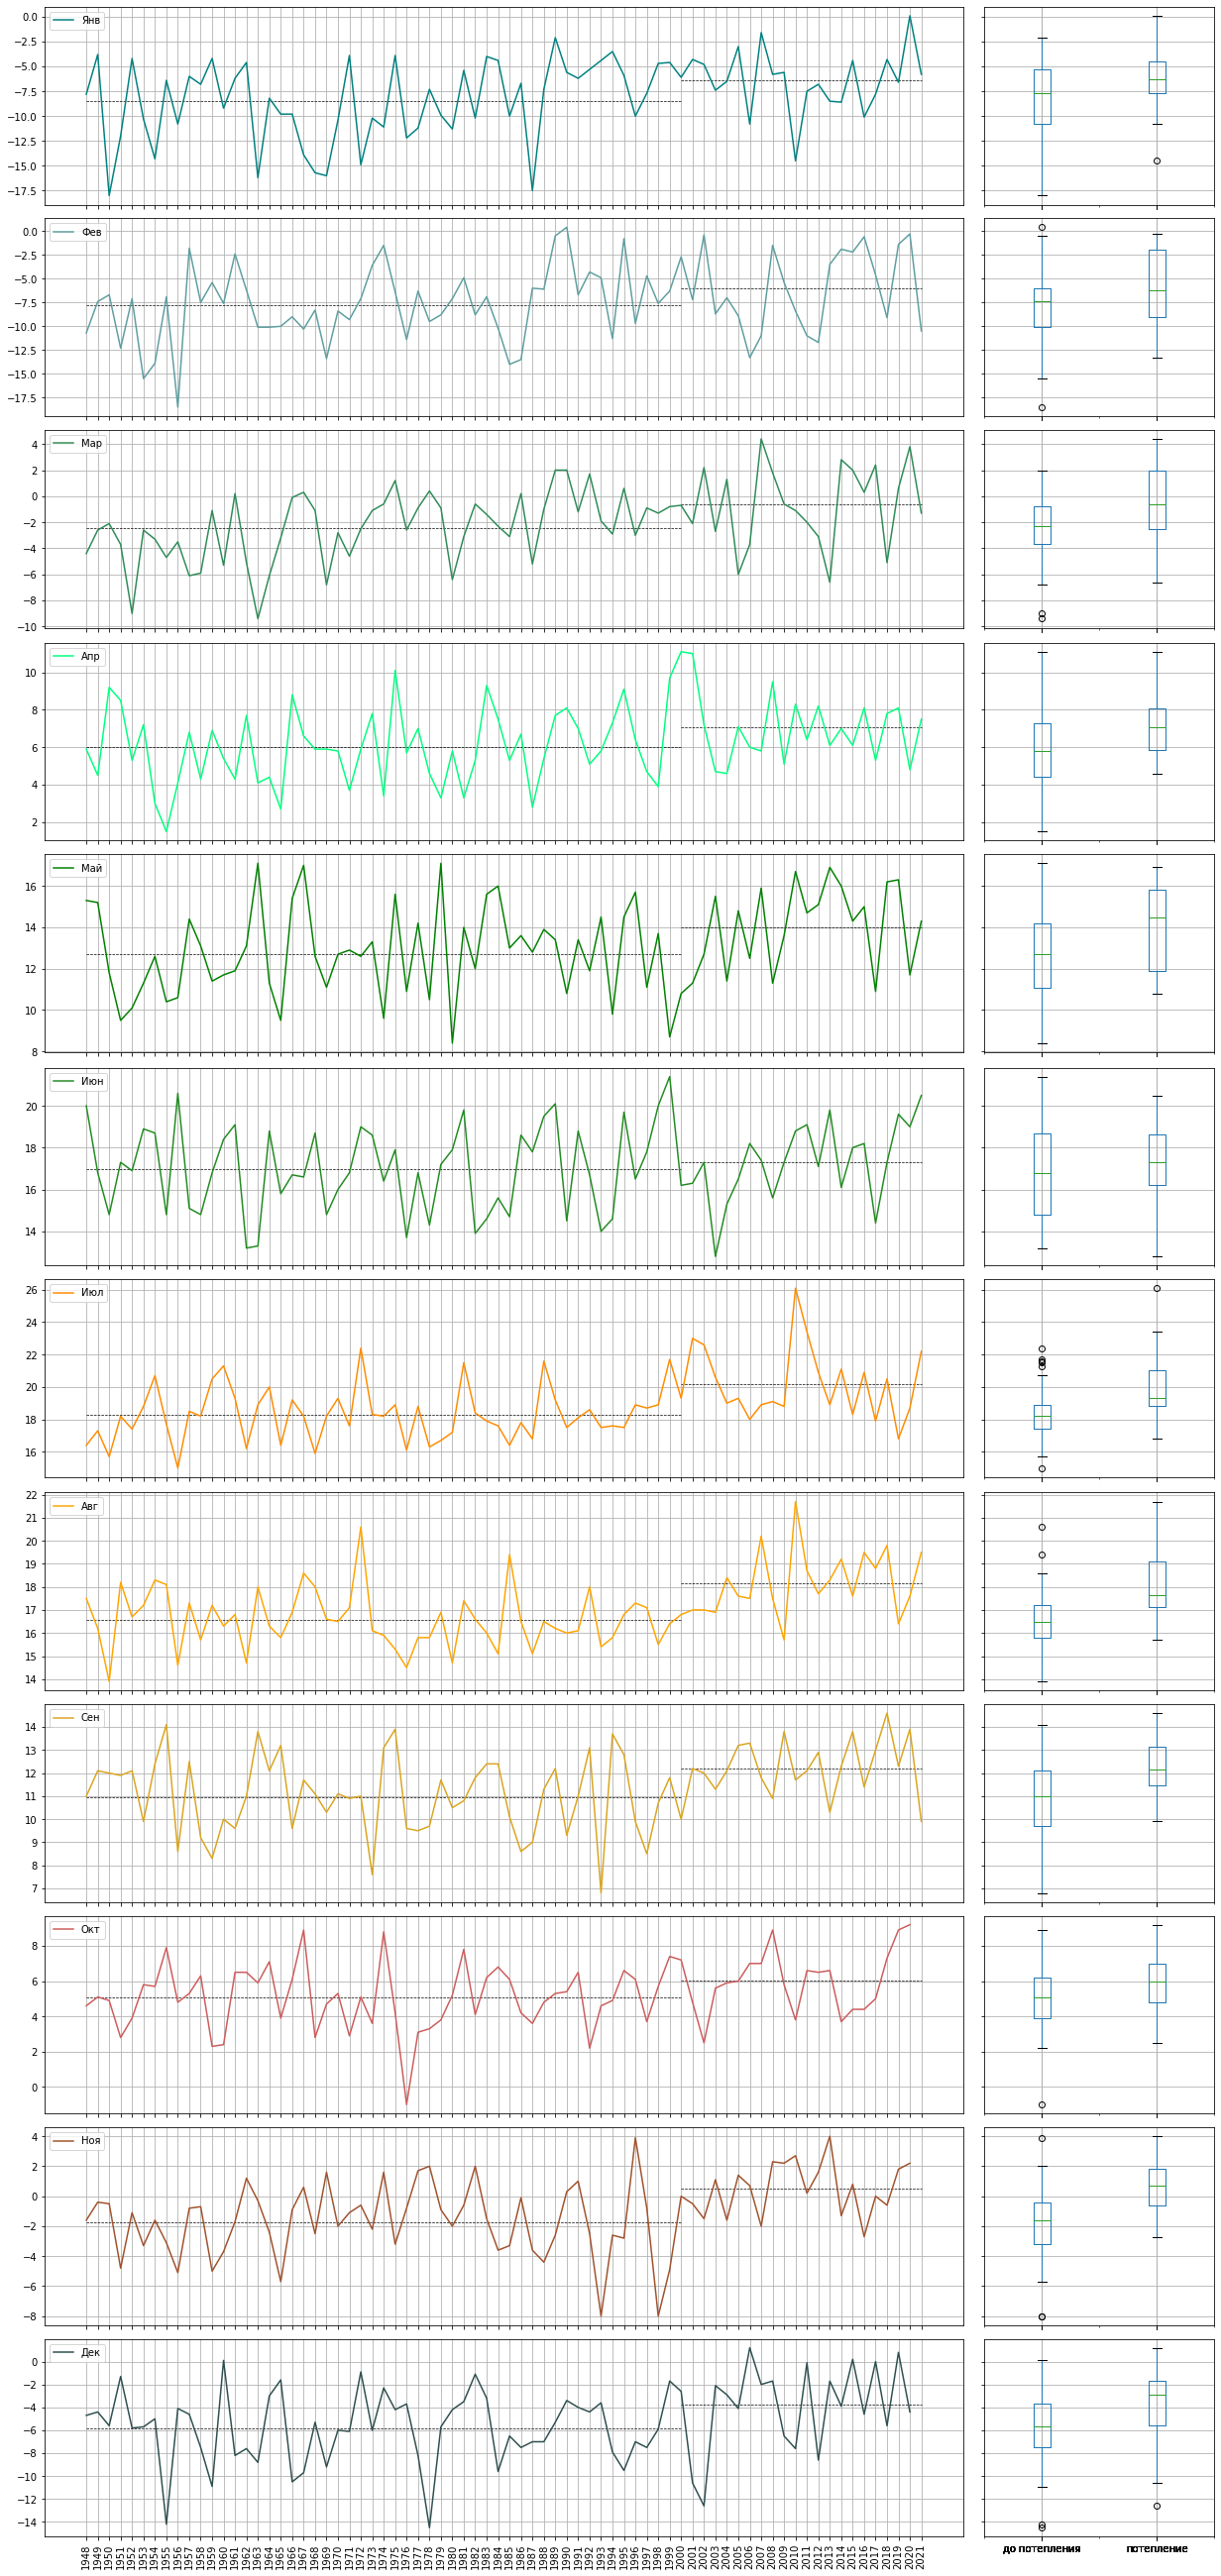

In [8]:
climate_change = 2000

_ma = mosTemp.reset_index()
_ma['month'] = _ma['date'].dt.month
_ma['year'] = _ma['date'].dt.year
_ma = _ma[['year', 'month', 'tempC']].set_index(['year', 'month']).unstack(level=-1)
_ma.columns = [c[1] for c in _ma.columns]

plot_temp1(_ma, legends_dict=dctMonths, 
           colors=['teal', 'cadetblue', 
                   'seagreen', 'springgreen', 'green', 
                   'forestgreen', 'darkorange', 'orange',
                   'goldenrod', 'indianred', 'sienna', 
                   'darkslategrey'
                  ]);

### Сравнение по сезонам

**Зимы считаются по сезонам: то есть декабрь 19-го года считается в зиме 20-го**

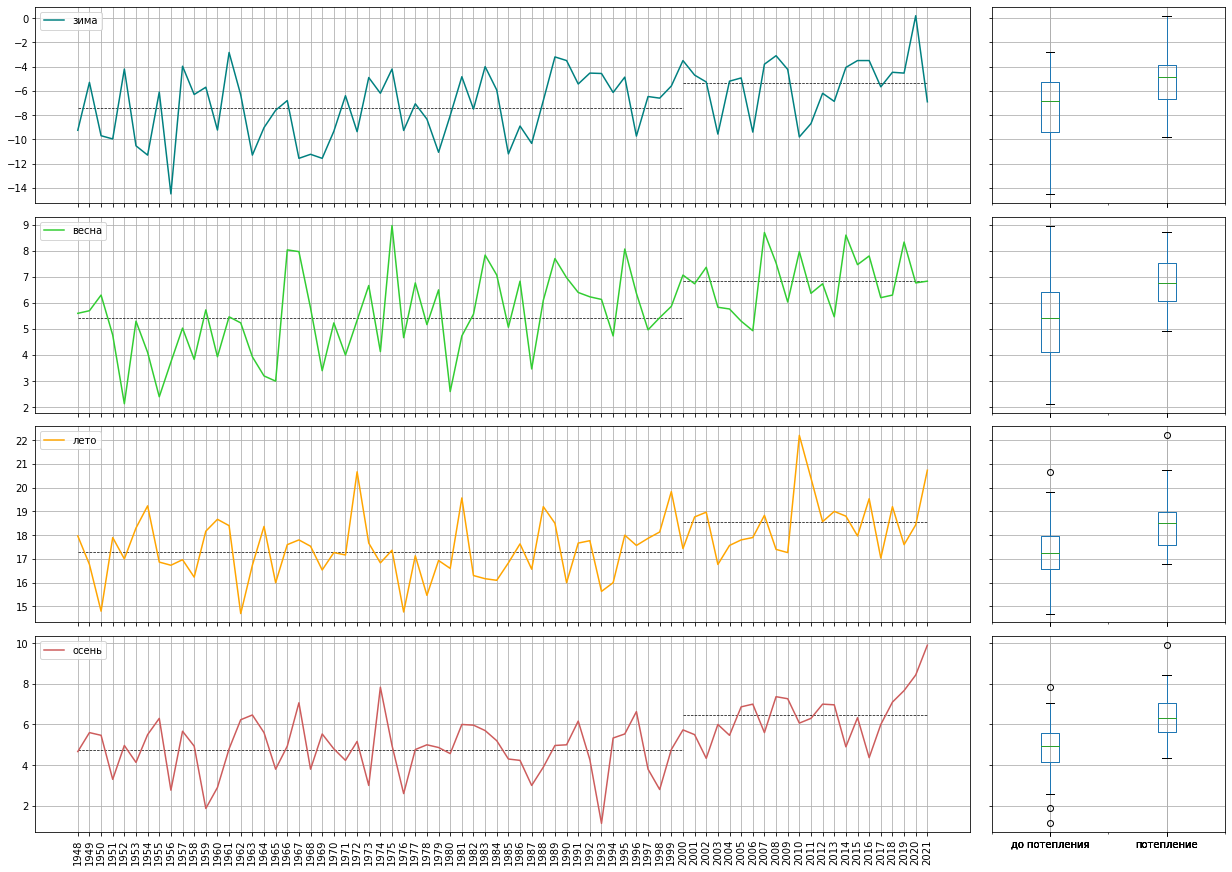

In [9]:
def mark_season(x):
    if x.month in [1, 2, 12]:
        return 1
    elif x.month in [3, 4, 5]:
        return 2
    elif x.month in [6, 7, 8]:
        return 3
    else:
        return 4

pdfSeason = mosTemp.copy()    
    
pdfSeason['season'] = pdfSeason.index.map(mark_season)
pdfSeason['syear'] = pdfSeason.index.year
pdfSeason.loc[pdfSeason.index.month==12, 'syear']+=1

pdfSeason = pdfSeason.groupby(by=['syear', 'season'])['tempC'].mean().unstack().reset_index()[['syear', 1, 2, 3, 4]].set_index('syear')
pdfSeason.columns=[1, 2, 3, 4]

plot_temp1(pdfSeason);

### По годам

**А вот тут зима считается по годам: декабрь 19-го идет как 19-й год**

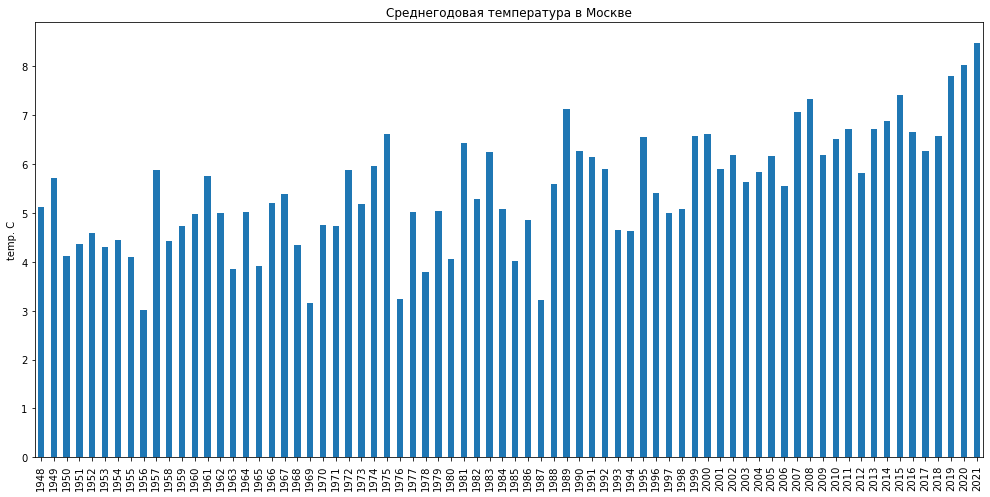

In [195]:
mosYT = mosTemp[['tempC']]
mosYT = mosYT.groupby(pd.Grouper(freq='Y')).mean()
mosYT.index=mosYT.index.year
axy = mosYT.plot.bar(figsize=(17, 8), legend=False, ylabel='temp. C', title='Среднегодовая температура в Москве', xlabel='');
# axy.set_xticks(ticks=mosYT.index.tolist())
